# Simulation d'une batterie de véhicule électrique

*Ecrit par Marc Budinger, INSA Toulouse, France*


##  Pack batteries du Goupil G4

Nous allons chercher à modéliser à modéliser le pack batteries de l'utilitaire Goupil G4. Les figures suivantes localisent cette batterie de traction dans le véhicule. 

*Localisation de la batterie de traction du G4*  
![G4](./figures/LocalisationBattteryG4.png)

Les caracétristiques générales de la batterie sont :
- Tension nominale : 48.3V
- Capacité : 200 Ah
- Energie : 9.6 kWh

On supposere dans la suite du sujet que cette batterie est constituée de cellules LiFePO4 50Ah tels que décrite dans la thèse de [[Damay, 2015](#références)]. La tension de la cellule varie entre 2.5 et 3.65 V pour une tension nominale de 3.22 V.

*Cellule LiFePO4 50 Ah*  
![G4](./figures/Cell50Ah.png)

Le pack batterie est constitués de modules, assemblage de ces cellules élémentaires.

*Module*  
![G4](./figures/Module.png)

> **Question :** Proposer une configuration possible pour ce pack batterie : nombre de modules, configurations des modules ($n_s$, $n_p$). On veut limiter la taille des modules à 2P8S.

In [36]:
# Pack
C = 200 # [Ah] capacité du pack
Ubat=48.3 # [V] tension du pack

# Cellule
Ccell = 50 # [Ah] capacité d'une cellule
Ucell = 3.22 # [V] tension nominale d'une cellule 

# Architecture
np = C / Ccell # [-] nb de cellulles en //
ns = Ubat / Ucell # [-] nb de cellules en série

print("np = %.1f"%np)
print("ns = %.1f"%ns)
print("Soit 2 modules 2P7S en série avec 2 modules 2P8S")

np = 4.0
ns = 15.0
Soit 2 modules 2P7S en série avec 2 modules 2P8S


## Tension en fonction de l'état de charge

Il est conventionnel de modéliser une batterie par une source de tension constante. Cette tension en circuit ouvert (OCV) varie en réalité en fonction de l'état de charge comme illustré sur la figure ci-dessous. 

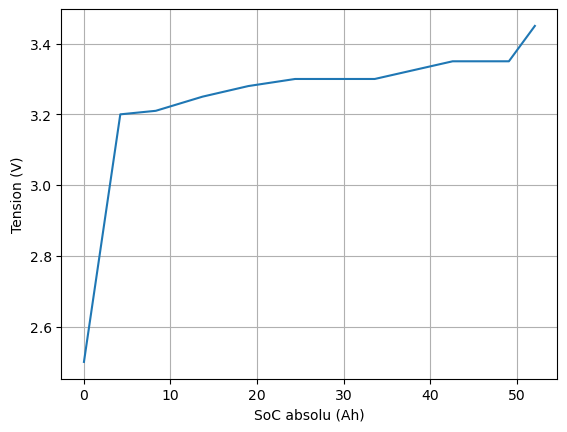

[0.         0.0806142  0.15930902 0.26295585 0.3646833  0.46833013
 0.55662188 0.64491363 0.81765835 0.88099808 0.94241843 1.        ]
[2.5, 3.2, 3.21, 3.25, 3.28, 3.3, 3.3, 3.3, 3.35, 3.35, 3.35, 3.45]


In [38]:
import numpy as np
import matplotlib.pyplot as plt

Charge = [0, 4.2, 8.3, 13.7, 19.0, 24.4, 29.0, 33.6, 42.6, 45.9, 49.1, 52.1]
SOT = np.array(Charge) / max(Charge)
Tension = [2.5, 3.2, 3.21, 3.25, 3.28,3.3,3.3,3.3,3.35,3.35,3.35,3.45]

plt.plot(Charge, Tension)

plt.xlabel("SoC absolu (Ah)")
plt.ylabel("Tension (V)")

plt.grid()
plt.show() # affiche la figure à l'écran

print(SOT)
print(Tension)

> **Exercice :** Proposer une modèle modélica permettant de représenter cette source de tension fonction de l'état de charge. 

## Resistance série et phénomène de diffusion

Une batterie n'est également pas une source de tension parfaite : une impédance série fait varier la tension observable au borne de le cellule en cas de charge ou de décharge. La figure suivante représente la réponse en tension à un créneau de courant de charge (mesure effectuée sur la cellule étudiée, à environ 50 % SoC, régime C/2, 32 °C).

*Réponse en tension à un créneau de courant [[Damay, 2015](#références)]*  
![Chareg pulse](./figures/ChargePulse.png)

> **Exercice :** Proposer une impédance série simple et composée de résistances et condensateurs permettant de représenter la chute de tension mesurée. Identifier graphiquement les valeurs des paramètres. Valider par simulation [python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html) et Modelica.


R1 = 1.00e-03 Ohm
R2 = 1.88e-03 Ohm
C2 = 3.19e+04 F


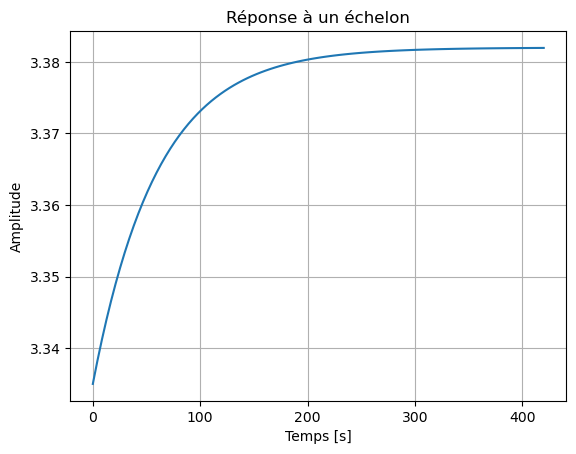

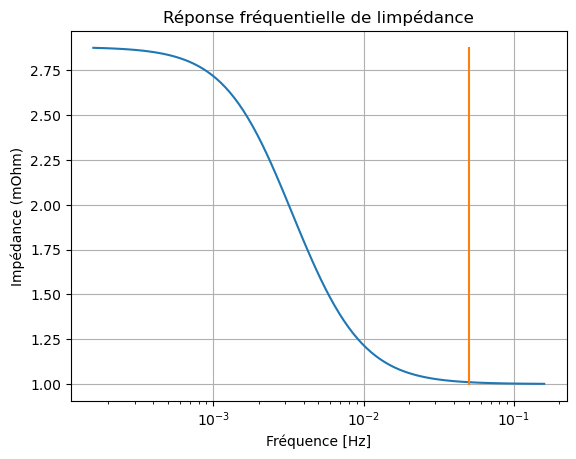

In [30]:
from scipy import signal
import matplotlib.pyplot as plt

# On suppose l'impedance de la forme
#          --- R2 --- 
# --- R1 --          -----
#          --- C2 ---

# Identification
I = 25 # [A] échelon de courant
U0 = 3.31 # [V] tension circuit ouvert

DU1 = 3.335-U0 # [V] reponse instantanee 
DUf = 3.382-U0 # [V] reponse finale

R1 = DU1 / I # [Ohm] impedance serie
R2 = DUf / I - R1 # [Ohm] impedance //

TauDiff = 60 # [s] constante de temps de diffusion

C2 = TauDiff / R2 # [F] capcisité de diffusion

print("R1 = %.2e Ohm"%R1)
print("R2 = %.2e Ohm"%R2)
print("C2 = %.2e F"%C2)

# fonction de transfert

Z = signal.lti([R1*TauDiff, R1+R2], [TauDiff, 1])

# Réponse temporelle à un échelon
t, y = signal.step(Z)
plt.plot(t, y*I+U0)
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')
plt.title('Réponse à un échelon')
plt.grid()

# Réponse fréquentielle, notemment à 1/20 Hz

w, mag, phase = signal.bode(Z)
plt.figure()
plt.semilogx(w/2/3.14, 10**(mag/20)*1e3)    # Bode magnitude plot
plt.semilogx([1/20]*2, [min(10**(mag/20)*1e3), max(10**(mag/20)*1e3)])
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Impédance (mOhm)')
plt.title('Réponse fréquentielle de l''impédance')
plt.grid()


## Modélisation de la réponse thermique d'une cellule

Les batteries LiFePO4 sont généralement conçues pour fonctionner dans une [plage de température de -20 ° C à 60 ° C](https://www.lithiumbatterytech.com/fr/lifepo4-battery-temperature-range/). Bien qu'elles aient une plage de températures de fonctionnement plus large que d'autres chimies de cellules, il est important d'analyser les température d'utilisation ou de stockage afin d'éviter :
- un **vieillissement accéléré**:  le fonctionnement d'une batterie LiFePO4 à 60°C peut entraîner une durée de vie qui ne représente que 50 à 70 % de celle attendue à 25°C.
- une **augmentation de l'autodécharge**: par exemple, une batterie LiFePO4 stockée à 40°C peut présenter un taux d'autodécharge 2 à 3 fois plus élevé que lorsqu'elle est stockée à 25°C. Cette autodécharge accrue peut entraîner une capacité réduite de la batterie et une durée de conservation plus courte.

Pour la suite de l'étude, nous allons réaliser quelques hypothèses simpificatrices afin de simuler la réponse thermique d'une cellule :
- nous négligerons les échanges de chaleur entropique par rapports aux pertes électriques (calculable par l'impédance série)
- nous supposerons que le transfert de chaleur se fait principalement vers la base de la cellule et du module. Cette base pourra si necessaire etre réfroidie par un dispositif spécifique. 
- nous supposerons la température homogène au sein de la cellule. 

*Flux thermiques dans la cellule*
![Flux thermiques](./figures/FluxChaleur.png)

La figure suivante représente la réponse en température de la cellule étudiée pour pour un courant carré d'amplitude +/-40A de période 20s appliqué pendant 1h.

*Réponse thermique d'une cellule [[Damay, 2015](#références)]*
![Flux thermiques](./figures/ReponseThermique.png)

> **Exercice :** Proposer un modèle thermique à base de résistance et capacité thermique le plus simple possible permettant de représenter certe réponse et le problème étudié. Identifier les paramètres et valider votre modèles par simulation python et Modelica.

Cth = 3.56e+02 J/K
Rth = 1.10e+01 K/W


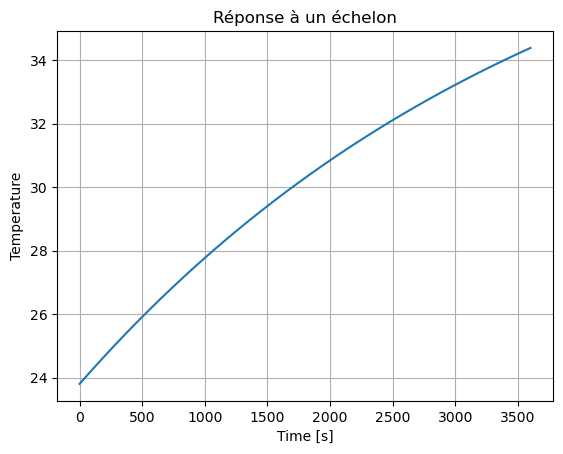

In [29]:
import numpy as np
# Pour l'impedance de la forme
#          --- R2 --- 
# --- R1 --          -----
#          --- C2 ---

# A la fréquence de 1/20 Hz, seul R1 est actif.
# On suppose donc Z=R1

# Pertes Joules
Pj=R1 * 40**2

# Identification de la capacité
# Pth = Cth DTheta / DT 

DTheta=1.8 # [K]
DT = 400 # [s]

Cth = Pj/(DTheta / DT)

# Identification de la résistance par identification su réponse indicielle
# on a un 1er ordre thermique


Rth = 11
H = signal.lti([Rth], [Rth*Cth, 1])

t = np.linspace(0,3600,100)

# Réponse temporelle à un échelon

t, y = signal.step(H, T=t)
plt.plot(t, y*Pj+23.8)
plt.xlabel('Temps [s]')
plt.ylabel('Temperature [°C]')
plt.title('Réponse à un échelon')
plt.grid()

print("Cth = %.2e J/K"%Cth)
print("Rth = %.2e K/W"%Rth)

## Modélisation et simulation du pack batterie complet

> **Exercice :** Représenter sous Modelica la cellule, les modules et les associations de module en un pack représentatif de la batterie de traction du goupil G4. Utiliser pour cela le fichier [fourni](./modelica/Goupil_Batterie.mo). Simuler la réponse électrique et thermique de ce pack sous le profil de mission de test. 


## Références

Certaines données et graphiques de ce Notebook sont issus de la thèse suivante:   

**[Damay, 2015]** Damay, N. (2015). Contribution à la modélisation thermique de packs batteries LiFePO4 pour véhicules décarbonés (Doctoral dissertation, Université de Technologie de Compiègne). [Link](https://theses.hal.science/tel-01310498)    

> Mais il est a noter que le présent document a effectué de nombreuses hypthèses simplificatrices pour des raisons pédagogiques. Les résultas présentés ici ne sont donc pas l'image de l'amplitude du travail de [Damay, 2015].